In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# 导入包

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data.dataloader import DataLoader

In [3]:
#设置transform，并批归一化
transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [4]:
#下载数据集和训练集
trainset = datasets.CIFAR10("data",train=True,download=True,transform=transform)
testset = datasets.CIFAR10("data",train=False,download=True,transform=transform)

# 批量读取数据

BATCH_SIZE = 16

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([16, 3, 32, 32])
torch.Size([16])


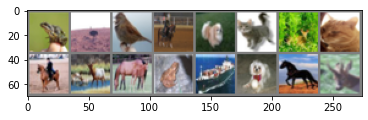

 frog  bird  bird horse   dog   cat  deer   cat horse  deer horse  frog  ship   dog horse  deer


In [5]:
# 可视化显示
import matplotlib.pyplot as plt
import numpy as np

# 10个类别
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # 逆正则化
    np_img = img.numpy() # tensor --> numpy
    plt.imshow(np.transpose(np_img, (1, 2, 0))) # 改变通道顺序
    plt.show()
    
# 随机获取一批数据
imgs, labs = next(iter(train_loader))

print(imgs.shape)
print(labs.shape)

# 调用方法
imshow(torchvision.utils.make_grid(imgs))

# 输出这批图片对应的标签
print(' '.join('%5s' % classes[labs[i]] for i in range(BATCH_SIZE)))

In [6]:
# 定义网络模型

import torch.nn as nn
import torch.nn.functional as F

"""
知识点：
1. 特征图尺寸的计算公式为：[(原图片尺寸 - 卷积核尺寸 + 填充) / 步长 ] + 1
"""
"""
模型的设计：

开始->卷积->激活->池化->卷积->激活->池化->全连接->激活->全连接->激活->全连接->结束

"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层1， 输入是32*32*3，计算（32-5）/ 1 + 1 = 28，那么通过conv1输出的结果是28*28*6
        self.conv1 = nn.Conv2d(3, 6, 5) # input:3, output:6, kernel:5
        # 池化层，  输入是28*28*6，窗口2*2，计算28 / 2 = 14，那么通过max_pool1层输出结果是14*14*6
        self.pool = nn.MaxPool2d(2, 2) # kernel:2, stride:2
        # 卷积层2， 输入是14*14*6，计算（14 - 5）/ 1 + 1 = 10，那么通过conv2输出的结果是10*10*16
        self.conv2 = nn.Conv2d(6, 16, 5) # input:6, output:16, kernel:5
        # 全连接层1
        self.fc1 = nn.Linear(16*5*5, 120) # input:16*5*5, output:120
        # 全连接层2
        self.fc2 = nn.Linear(120, 84) # input:120, output:84
        # 全连接层3
        self.fc3 = nn.Linear(84, 10) # input:84, output:10
        
    def forward(self, x):
        # 卷积1 
        """
        32x32x3 --> 28x28x6 --> 14x14x6
        """
        x = self.pool(F.relu(self.conv1(x)))
        # 卷积2
        """
        14x14x6 --> 10x10x16 --> 5x5x16
        """
        x = self.pool(F.relu(self.conv2(x)))
        # 改变shape
        x = x.view(-1, 16*5*5) #除了batchsize，把其他维的都铺平成一维
        # 全连接层1
        x = F.relu(self.fc1(x))
        # 全连接层2
        x = F.relu(self.fc2(x))
        # 全连接层3
        x = self.fc3(x)
        return x

In [7]:
# 创建模型
net = Net().to('cpu')

In [8]:
# 定义优化器和损失函数
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # 交叉熵损失函数

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 优化器

In [9]:
# 定义轮数
EPOCHS = 100

for epoch in range(EPOCHS):
    
    train_loss = 0.0
    for i, (datas, labels) in enumerate(train_loader):
        datas, labels = datas.to('cpu'), labels.to('cpu')
        # 梯度置零
        optimizer.zero_grad()
        # 训练
        outputs = net(datas)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        # 累计损失
        train_loss += loss.item()
    # 打印信息
    print("Epoch :%d , Batch : %5d , Loss : %.3f"%(epoch+1, i+1, train_loss/len(train_loader.dataset)))

C:\Users\17513\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch :1 , Batch :  3125 , Loss : 0.127
Epoch :2 , Batch :  3125 , Loss : 0.098
Epoch :3 , Batch :  3125 , Loss : 0.088
Epoch :4 , Batch :  3125 , Loss : 0.081
Epoch :5 , Batch :  3125 , Loss : 0.076
Epoch :6 , Batch :  3125 , Loss : 0.073
Epoch :7 , Batch :  3125 , Loss : 0.069
Epoch :8 , Batch :  3125 , Loss : 0.066
Epoch :9 , Batch :  3125 , Loss : 0.063
Epoch :10 , Batch :  3125 , Loss : 0.061
Epoch :11 , Batch :  3125 , Loss : 0.058
Epoch :12 , Batch :  3125 , Loss : 0.056
Epoch :13 , Batch :  3125 , Loss : 0.054
Epoch :14 , Batch :  3125 , Loss : 0.052
Epoch :15 , Batch :  3125 , Loss : 0.050
Epoch :16 , Batch :  3125 , Loss : 0.049
Epoch :17 , Batch :  3125 , Loss : 0.047
Epoch :18 , Batch :  3125 , Loss : 0.046
Epoch :19 , Batch :  3125 , Loss : 0.044
Epoch :20 , Batch :  3125 , Loss : 0.043
Epoch :21 , Batch :  3125 , Loss : 0.042
Epoch :22 , Batch :  3125 , Loss : 0.040
Epoch :23 , Batch :  3125 , Loss : 0.039
Epoch :24 , Batch :  3125 , Loss : 0.038
Epoch :25 , Batch :  3125

In [10]:
# 保存模型
PATH = './cifar_net.pth'

torch.save(net.state_dict(), PATH)

In [11]:
# 加载模型

model = Net()

model.load_state_dict(torch.load(PATH)) 

<All keys matched successfully>

In [12]:
# 测试
correct = 0
total = 0
with torch.no_grad():
    for i , (datas, labels) in enumerate(test_loader):
        # 输出
        outputs = model(datas) # outputs.data.shape --> torch.Size([16, 10])
        _, predicted = torch.max(outputs.data, dim=1) # 第一个是值的张量，第二个是序号的张量
        # 累计数据量
        total += labels.size(0)  # labels.size() --> torch.Size([16]) , labels.size(0) --> 16
        # 比较有多少个预测正确
        correct += (predicted == labels).sum() # 相同为1，不同为0，利用sum()求总和
    print("在10000张测试集图片上的准确率：{:.3f}%".format(correct / total * 100))

在10000张测试集图片上的准确率：59.680%
